# Intro

In [5]:
import spacy


nlp = spacy.load("en_core_web_sm")

In [6]:
# Process sentences 'Hello, world. Antonio is learning Python.' using spaCy
doc = nlp(u"Hello, world. Antonio is learning Python.")

## Get tokens and sentences

#### What is a Token?
A token is a single chopped up element of the sentence, which could be a word or a group of words to analyse. The task of chopping the sentence up is called "tokenisation".

Example: The following sentence can be tokenised by splitting up the sentence into individual words.

	"Antonio is learning Python!"
	["Antonio","is","learning","Python!"]

In [7]:
# Get first token of the processed document
token = doc[0]
print(token)

# Print sentences (one sentence per line)
for sent in doc.sents:
    print(sent)

Hello
Hello, world.
Antonio is learning Python.


## Part of speech tags

#### What is a Speech Tag?
A speech tag is a context sensitive description of what a word means in the context of the whole sentence.
More information about the kinds of speech tags which are used in NLP can be [found here](http://www.winwaed.com/blog/2011/11/08/part-of-speech-tags/).

Examples:

1. CARDINAL, Cardinal Number - 1,2,3
2. PROPN, Proper Noun, Singular - "Jan", "Javier", "Antonio", "Italy"
3. INTJ, Interjection - "Ohhhhhhhhhhh"

In [8]:
# For each token, print corresponding part of speech tag
for token in doc:
    print("{} - {}".format(token, token.pos_))

Hello - INTJ
, - PUNCT
world - NOUN
. - PUNCT
Antonio - PROPN
is - AUX
learning - VERB
Python - PROPN
. - PUNCT


In [9]:
from spacy import displacy

In [10]:
displacy.serve(doc, style='dep')



/home/lpianta/anaconda3/envs/NLP/lib/python3.8/site-packages/spacy/displacy/__init__.py:97: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'dep' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


In [11]:
displacy.render(doc, style = "ent",jupyter = True)


We have said that dependency structures are represented by directed graphs that satisfy the following constraints:

1. There is a single designated root node that has no incoming arcs.

2. With the exception of the root node, each vertex has exactly one incoming arc.

3. There is a unique path from the root node to each vertex in V.

You can inspect the head of each token by invoking the `.head` attribute of a spaCy token:


In [12]:
doc[2]

world

In [13]:
doc[2].head

Hello

So how would you search for the root?

Since there is a unique path from the root node to each vertex in V, there's only one root node that has no incoming arcs, we can search for the token which have as head itself!

In [14]:
for token in doc:
    if token.head == token:
        print(token)

Hello
learning


As expected, since there were two sentences in the doc, we got two roots.

We can also build a function that, given a spaCy token, gives the path till the root:

In [15]:
def path_to_the_root(token):
    if token.head == token:
        return
    else:
        print(f"{token}->{token.head}")
        path_to_the_root(token.head)

In [16]:
path_to_the_root(doc[4])

Antonio->learning


# Pride and Prejudice analysis

We would like to:

- Extract the names of all the characters from the book (e.g. Elizabeth, Darcy, Bingley)
- Visualize characters' occurences with regards to relative position in the book
- Authomatically describe any character from the book
- Find out which characters have been mentioned in a context of marriage
- Build keywords extraction that could be used to display a word cloud (example)

To load the text file, it is convinient to decode using the utf-8 standard:

In [17]:
def read_file(file_name):
    with open(file_name, "r", encoding="utf-8") as file:
        return file.read()

### Process full text

In [18]:
text = read_file("data/pride_and_prejudice.txt")
processed_text = nlp(text)

In [19]:
# How many sentences are in the book (Pride & Prejudice)?

sentences = [s for s in processed_text.sents]
print(len(sentences))
print(len(list(processed_text.sents)))
# Print sentences from index 10 to index 15, to make sure that we have parsed the correct book
print(sentences[10:20])

6814
6814
[It is a truth universally acknowledged, that a single man in possession
of a good fortune, must be in want of a wife., 

, However little known the feelings or views of such a man may be on his
first entering a neighbourhood, this truth is so well fixed in the minds
of the surrounding families, that he is considered the rightful property
of some one or other of their daughters., 

"My dear Mr. Bennet," said his lady to him one day, "have you heard that
Netherfield Park is let at last?", 

Mr. Bennet replied that he had not., 

", But it is," returned she; "for Mrs. Long has just been here, and she
told me all about it.", 

Mr. Bennet made no answer., 

"Do you not want to know who has taken it?" cried his wife impatiently., 

"_You_ want to tell me, and I have no objection to hearing it."]


## Find all the personal names

In [20]:
# Extract all the personal names from Pride & Prejudice and count their occurrences.
# Expected output is a list in the following form: [('elizabeth', 622), ('darcy', 312), ('jane', 286), ('bennet', 266) ...].

from collections import Counter, defaultdict


def find_character_occurences(doc):
    """
    Return a list of actors from `doc` with corresponding occurences.

    :param doc: Spacy NLP parsed document
    :return: list of tuples in form
        [('elizabeth', 622), ('darcy', 312), ('jane', 286), ('bennet', 266)]
    """

    characters = Counter()
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            characters[ent.lemma_] += 1

    return characters.most_common()


print(find_character_occurences(processed_text)[:20])

[('Elizabeth', 617), ('Darcy', 391), ('Jane', 267), ('Bennet', 229), ('Wickham', 176), ('Collins', 168), ('Bingley', 133), ('Lizzy', 94), ('Lady Catherine', 88), ('Gardiner', 87), ('Miss Bingley', 53), ('Meryton', 48), ('Fitzwilliam', 34), ('William', 31), ('Hurst', 29), ('Miss Bennet', 29), ('Phillips', 22), ('Project Gutenberg - tm', 22), ('Brighton', 21), ('Forster', 20)]


## Plot characters personal names as a time series 

In [21]:
# Matplotlib Jupyter HACK
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

We can investigate where a particular entity occurs in the text. We can do it just accessing the `.start` attribute of an entity:


In [22]:
for ent in processed_text.ents:
    if ent.label_ == "PERSON":
        print(ent.start)

10
70
74
128
136
228
255
275
293
355
406
417
515
647
746
793
795
859
908
922
944
997
1012
1181
1285
1296
1371
1376
1393
1422
1438
1452
1496
1519
1550
1622
1649
1701
1713
1787
1835
1969
2102
2172
2186
2310
2370
2393
2425
2475
2485
2554
2580
2610
2613
2709
2733
2762
2819
2855
2933
2953
2996
3008
3079
3167
3232
3239
3243
3317
3342
3370
3413
3531
3601
3673
3751
3757
3762
3833
3850
3870
3872
3883
3896
3957
4038
4070
4091
4188
4225
4234
4242
4251
4376
4416
4432
4533
4535
4552
4622
5005
5039
5249
5284
5383
5400
5430
5503
5524
5566
5589
5603
5656
5672
5730
5743
5805
5848
5884
5898
5994
6078
6099
6126
6185
6202
6228
6278
6293
6305
6313
6360
6440
6474
6510
6551
6559
6578
6606
6612
6668
6700
6731
6735
6755
6807
6891
6921
7063
7201
7212
7214
7257
7270
7298
7350
7403
7455
7692
7746
7788
7844
7890
7940
8050
8084
8089
8261
8268
8293
8524
8541
8559
8570
8648
8664
8685
8710
8758
8771
8853
8883
9005
9049
9073
9135
9172
9181
9198
9258
9300
9310
9403
9445
9470
9503
9513
9567
9596
9636
9657
9664
9687
9739


So we can create a function that stores all the offsets of every character:
    

In [23]:
def get_character_offsets(doc):
    """
    For every character in a `doc` collect all the occurences offsets and store them into a list.
    The function returns a dictionary that has actor lemma as a key and list of occurences as a value for every character.

    :param doc: Spacy NLP parsed document
    :return: dict object in form
        {'elizabeth': [123, 543, 4534], 'darcy': [205, 2111]}
    """

    character_offsets = {}
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            if ent.lemma_.lower() not in character_offsets:
                character_offsets[ent.lemma_.lower()] = [ent.start]
            else:
                character_offsets[ent.lemma_.lower()].append(ent.start)
    return dict(character_offsets)


character_occurences = get_character_offsets(processed_text)

In [24]:
# Plot characters' mentions as a time series relative to the position of the actor's occurrence in a book.


def get_character_offsets(doc):
    """
    For every character in a `doc` collect all the occurences offsets and store them into a list.
    The function returns a dictionary that has actor lemma as a key and list of occurences as a value for every character.

    :param doc: Spacy NLP parsed document
    :return: dict object in form
        {'elizabeth': [123, 543, 4534], 'darcy': [205, 2111]}
    """

    character_offsets = defaultdict(list)
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            character_offsets[ent.lemma_.lower()].append(ent.start)

    return dict(character_offsets)


character_occurences = get_character_offsets(processed_text)

In [25]:
character_occurences

{'jane austen': [10, 74, 136, 155588],
 'prejudice': [70],
 'anonymous volunteers \n\n\n\n\n\n pride and': [128],
 'bennet': [228,
  255,
  293,
  515,
  1012,
  1181,
  1285,
  1496,
  1519,
  1713,
  1835,
  2102,
  2186,
  2370,
  2393,
  2580,
  2613,
  2709,
  2762,
  3317,
  3601,
  3957,
  4038,
  4376,
  5848,
  6099,
  6185,
  6360,
  7201,
  10191,
  10729,
  10863,
  11037,
  11070,
  11274,
  11425,
  11585,
  11748,
  15473,
  15502,
  15623,
  15754,
  16235,
  16294,
  17213,
  17578,
  22708,
  23297,
  23510,
  23629,
  23972,
  24027,
  24640,
  25088,
  25165,
  25506,
  25567,
  25645,
  25720,
  26012,
  26126,
  26466,
  26566,
  26642,
  26942,
  26955,
  26979,
  27046,
  27387,
  27450,
  27601,
  27626,
  27704,
  27779,
  29054,
  29186,
  34154,
  34208,
  34231,
  39525,
  40029,
  40744,
  41185,
  41260,
  41330,
  41423,
  41525,
  41741,
  42045,
  44078,
  44217,
  44435,
  44473,
  44521,
  44579,
  44733,
  44851,
  44944,
  44973,
  45076,
  45350,


In [26]:
NUM_BINS = 20

def plot_character_hist(character_offsets, character_label, cumulative=False):
    x = character_offsets[character_label]
    plt.figure()
    n, bins, patches = plt.hist(x, NUM_BINS, label=character_label, cumulative=cumulative)
    

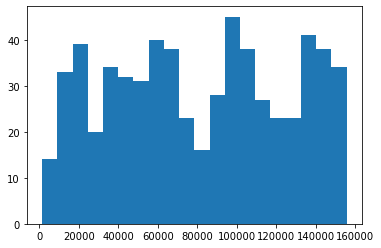

In [27]:
plot_character_hist(character_occurences, "elizabeth")

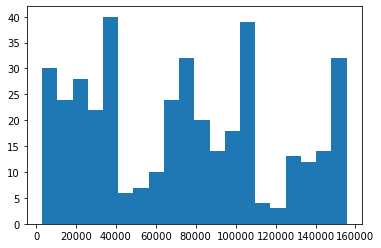

In [28]:
plot_character_hist(character_occurences, "darcy")

### Cumulative occurrences

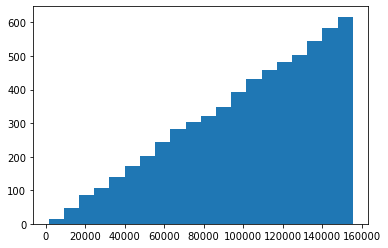

In [29]:
plot_character_hist(character_occurences, "elizabeth", cumulative=True)

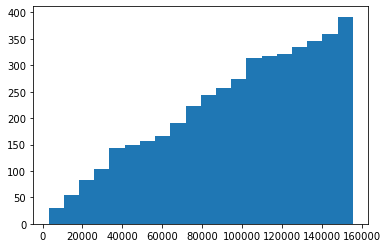

In [30]:
plot_character_hist(character_occurences, "darcy", cumulative=True)

### Spacy parse tree in action

In [31]:
# Find words (adjectives) that describe Mr. Darcy.

def get_character_adjectives(doc, character_lemma):
    """
    Find all the adjectives related to `character_lemma` in `doc`
    
    :param doc: Spacy NLP parsed document
    :param character_lemma: string object
    :return: list of adjectives related to `character_lemma`
    """
    
    adjectives = []
    for ent in processed_text.ents:
        if ent.lemma_.lower() == character_lemma:
            for token in ent.subtree:
                if token.pos_ == 'ADJ': # Replace with if token.dep_ == 'amod':
                    adjectives.append(token.lemma_)
    
    for ent in processed_text.ents:
        if ent.lemma_.lower() == character_lemma:
            if ent.root.dep_ == 'nsubj':
                for child in ent.root.head.children:
                    if child.dep_ == 'acomp':
                        adjectives.append(child.lemma_)
    
    return adjectives

print(get_character_adjectives(processed_text, 'darcy'))

['grave', 'delighted', 'late', 'late', 'late', 'late', 'intimate', 'confidential', 'present', 'infamous', 'steward', 'superior', 'opposite', 'late', 'late', 'few', 'poor', 'last', 'clever', 'worth', 'grow', 'studious', 'sorry', 'unworthy', 'answerable', 'impatient', 'ashamed', 'kind', 'handsome', 'down', 'proud', 'tall', 'punctual', 'delighted', 'fond']


In [32]:
# Find words (adjectives) that describe Elizabeth.

def get_character_adjectives(doc, character_lemma):
    """
    Find all the adjectives related to `character_lemma` in `doc`
    
    :param doc: Spacy NLP parsed document
    :param character_lemma: string object
    :return: list of adjectives related to `character_lemma`
    """
    
    adjectives = []
    for ent in processed_text.ents:
        if ent.lemma_.lower() == character_lemma:
            for token in ent.subtree:
                if token.pos_ == 'ADJ': # Replace with if token.dep_ == 'amod':
                    adjectives.append(token.lemma_)
    
    for ent in processed_text.ents:
        if ent.lemma_.lower() == character_lemma:
            if ent.root.dep_ == 'nsubj':
                for child in ent.root.head.children:
                    if child.dep_ == 'acomp':
                        adjectives.append(child.lemma_)
    
    return adjectives

print(get_character_adjectives(processed_text, 'elizabeth'))

['easy', 'unaffected', 'least', 'dear', 'young', 'dear', 'dear', 'dear', 'first', 'acute', 'dear', 'latter', 'lovely', 'more', 'glad', 'catch', 'surprised', 'surprised', 'deep', 'pleased', 'watchful', 'satisfied', 'prepared', 'equal', 'ready', 'thankful', 'surprised', 'surprised', 'eager', 'shocked', 'disappointed', 'distressed', 'delighted', 'rejoiced', 'sensible', 'prepared', 'pleased', 'relieve', 'pleased', 'pleased', 'surprised', 'sorry', 'surprised', 'disgust', 'glad', 'pleased', 'determined', 'more', 'embarrassed', 'acquainted']


For all the dependencies manual: https://nlp.stanford.edu/software/dependencies_manual.pdf

`acomp`: adjectival complement
*i.e.* an adjectival phrase which functions as the complement (like an object of the verb) e.g. "She looks very beautiful": *beautiful* is an adjectival complement of *looks*

`nsubj`: nominal subject
*i.e.* a noun phrase which is the syntactic subject of a clause. The head of this relation
might not always be a verb: when the verb is a copular verb, the root of the clause is the complement of
the copular verb, which can be an adjective or noun.
*e.g.* "Clinton defeated Dole". The relationship is *nsubj(defeated, Clinton)*

"The baby is cute". The relationship is *nsubj(cute, baby)*.

In the code, `.dep_`stands for syntactic dependency, *i.e.* the relation between tokens.

In [33]:
processed_text.ents[30].root.dep_

'pobj'

In [34]:
# Find characters that are 'talking', 'saying', 'doing' the most. Find the relationship between 
# entities and corresponding root verbs.

character_verb_counter = Counter()


for ent in processed_text.ents:
    if ent.label_ == 'PERSON' and ent.root.head.lemma_ == "say":
        character_verb_counter[ent.text] += 1

print(character_verb_counter.most_common(10)) 

for ent in processed_text.ents:
    if ent.label_ == 'PERSON' and ent.root.head.lemma_ == "do":
        character_verb_counter[ent.text] += 1

print(character_verb_counter.most_common(10)) 

for ent in processed_text.ents:
    if ent.label_ == 'PERSON' and ent.root.head.lemma_ == "talk":
        character_verb_counter[ent.text] += 1

print(character_verb_counter.most_common(10)) 


[('Elizabeth', 46), ('Bennet', 28), ('Jane', 14), ('Darcy', 13), ('Miss Bingley', 9), ('Fitzwilliam', 6), ('Bingley', 5), ('Gardiner', 5), ('Lady Catherine', 4), ('Wickham', 4)]
[('Elizabeth', 48), ('Bennet', 28), ('Darcy', 16), ('Jane', 14), ('Miss Bingley', 10), ('Gardiner', 8), ('Bingley', 7), ('Fitzwilliam', 6), ('Lady Catherine', 5), ('Lizzy', 5)]
[('Elizabeth', 48), ('Bennet', 28), ('Darcy', 16), ('Jane', 15), ('Miss Bingley', 10), ('Gardiner', 9), ('Bingley', 7), ('Lady Catherine', 7), ('Fitzwilliam', 6), ('Lizzy', 5)]


In [35]:
# Find 20 most used verbs
verb_counter = Counter()

for ent in processed_text.ents:
    if ent.label_ == "PERSON" and ent.root.head.pos_ == "VERB":
        verb_counter[ent.root.head.lemma_] += 1

print(verb_counter.most_common(20))

[('say', 159), ('be', 113), ('have', 67), ('see', 54), ('cry', 49), ('reply', 48), ('look', 30), ('make', 24), ('leave', 24), ('come', 23), ('think', 23), ('go', 18), ('begin', 17), ('give', 17), ('do', 16), ('tell', 16), ('take', 16), ('feel', 15), ('know', 15), ('marry', 15)]


In [36]:
# Create a dataframe with the most used verb and how many time a character used the verb

import pandas as pd
verb_characters = {}
verb_list = [verb[0] for verb in verb_counter.most_common(20)]
for ent in processed_text.ents:
    if ent.label_ == 'PERSON' and ent.root.head.lemma_ in verb_list:
        verb = ent.root.head.lemma_
        person = ent.text
        if verb not in verb_characters:
            verb_characters[verb] = {person:1}
        else:
            if ent.text not in verb_characters[verb]:
                verb_characters[verb][person] = 1
            else:
                verb_characters[verb][person] += 1


In [37]:
verb_counter.most_common(20)

[('say', 159),
 ('be', 113),
 ('have', 67),
 ('see', 54),
 ('cry', 49),
 ('reply', 48),
 ('look', 30),
 ('make', 24),
 ('leave', 24),
 ('come', 23),
 ('think', 23),
 ('go', 18),
 ('begin', 17),
 ('give', 17),
 ('do', 16),
 ('tell', 16),
 ('take', 16),
 ('feel', 15),
 ('know', 15),
 ('marry', 15)]

In [38]:
df = pd.DataFrame(verb_characters).transpose().fillna(0)
df

,Bennet,Elizabeth,Charlotte,Darcy,Wickham,Miss Bingley,Jane,Collins,William,Fitzwilliam,...,F.,Hill,Lydia Bennet,Sarah,Miss Bingley\n,Eliza Bennet,Lydia,Bakewell,Brighton,Lucas
reply,3.0,18.0,2.0,7.0,4.0,1.0,7.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
be,33.0,54.0,0.0,42.0,17.0,4.0,27.0,15.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
make,2.0,8.0,0.0,2.0,1.0,1.0,3.0,4.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
say,28.0,46.0,3.0,13.0,4.0,9.0,14.0,3.0,1.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
see,2.0,16.0,1.0,8.0,4.0,3.0,7.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
have,8.0,18.0,0.0,6.0,6.0,0.0,6.0,5.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
do,0.0,2.0,0.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
come,0.0,0.0,0.0,4.0,1.0,1.0,2.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
cry,3.0,24.0,0.0,3.0,1.0,3.0,6.0,2.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feel,0.0,12.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# drop the less meaningful columns
df = df[df.columns[df.sum()>=10]].sort_index()
df

,Bennet,Elizabeth,Darcy,Wickham,Miss Bingley,Jane,Collins,William,Fitzwilliam,Gardiner,Bingley,Lizzy,Lady Catherine
be,33.0,54.0,42.0,17.0,4.0,27.0,15.0,5.0,3.0,4.0,17.0,11.0,9.0
begin,1.0,3.0,0.0,3.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0
come,0.0,0.0,4.0,1.0,1.0,2.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0
cry,3.0,24.0,3.0,1.0,3.0,6.0,2.0,0.0,0.0,2.0,1.0,1.0,0.0
do,0.0,2.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,2.0,2.0,1.0
feel,0.0,12.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
give,3.0,2.0,3.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,3.0,0.0
go,2.0,4.0,0.0,3.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
have,8.0,18.0,6.0,6.0,0.0,6.0,5.0,1.0,0.0,0.0,3.0,5.0,2.0
know,0.0,3.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,4.0,2.0,0.0


In [40]:
import seaborn as sns
%matplotlib inline
sns.heatmap(df, annot=True, cmap='Blues')
df.style.background_gradient(cmap='Blues')


ModuleNotFoundError: No module named 'seaborn'